## PCA

Load and format dataset

In [1]:
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

data_df = pd.read_csv(os.path.join(DATA_DIR, "ec-taxa-media-overlap.csv"), low_memory=False)

filter = data_df["ec"].str.contains("-")
data_df = data_df[~filter]

data_df = data_df[["taxon_id", "media_id", "ec"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="ec",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df.head()

ec,taxon_id,media_id,1.1.1.1,1.1.1.103,1.1.1.11,1.1.1.119,1.1.1.14,1.1.1.18,1.1.1.2,1.1.1.22,...,3.5.2.10,3.5.2.6,3.5.3.1,3.5.3.3,3.5.5.1,4.1.1.73,4.2.1.32,4.4.1.1,6.2.1.57,6.3.1.20
0,1004166,1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1004261,J181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004261,J455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005925,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005926,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transform, cluster, and plot PCA

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
 
# Format to shape
data = data_df.drop(["taxon_id", "media_id"], axis=1)
pca = PCA(50)
df = pca.fit_transform(data)
df.shape

(7220, 50)

In [3]:
pcs = pd.DataFrame(df)
pca_df = data_df[["taxon_id", "media_id"]].join(pcs)
pca_df.head()

,taxon_id,media_id,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,1004166,1a,-6.499677,-0.461078,-1.635467,-0.753660,-0.215067,0.534075,-0.024268,0.306524,...,-0.001854,-0.075809,0.033026,-0.024502,0.044140,-0.049974,-0.035943,-0.026245,-0.073205,-0.034012
1,1004261,J181,-6.552281,-0.470831,-1.918951,-0.600825,-0.149785,0.458606,0.164980,0.291553,...,-0.041753,-0.008244,-0.089151,-0.057173,-0.039496,0.019461,0.012854,0.014100,0.006003,0.017014
2,1004261,J455,-6.552281,-0.470831,-1.918951,-0.600825,-0.149785,0.458606,0.164980,0.291553,...,-0.041753,-0.008244,-0.089151,-0.057173,-0.039496,0.019461,0.012854,0.014100,0.006003,0.017014
3,1005925,J118,-6.552281,-0.470831,-1.918951,-0.600825,-0.149785,0.458606,0.164980,0.291553,...,-0.041753,-0.008244,-0.089151,-0.057173,-0.039496,0.019461,0.012854,0.014100,0.006003,0.017014
4,1005926,J118,-6.697743,-1.454710,-1.816314,-0.628281,-0.135938,0.458449,0.153914,0.239984,...,-0.100815,-0.059291,0.061380,0.050511,0.005015,-0.014052,-0.014575,-0.086353,-0.105859,-0.021655


## UMAP

### Random fit, default = 2 dimensions

In [19]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(df)
embedding.shape

(7220, 2)

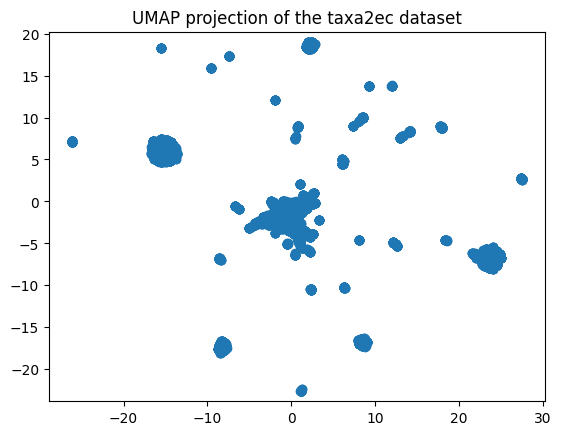

In [20]:
import seaborn as sns

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the taxa2ec dataset', fontsize=12);

### Splitting into training and test sets

In [44]:
TARGET_VAR = "taxon_id"
RANDOM_SEED = 666
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pca_df.drop(["taxon_id", "media_id"], axis=1),
    pca_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [46]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=3, # 4 components allows us to easily visualize in 3 dimensions, can reduce to 2-3
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

,Component 1,Component 2,Component 3
0,43.102425,-31.357597,-64.888351
1,-14.944263,28.323095,1.858287
2,19.352890,10.042732,32.780693
3,11.023548,-23.688835,19.882507
4,-0.348978,-10.678181,-4.068751


In [66]:
len(reduced_df)

5776

## Cluster

In [83]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load your dataset
data = reduced_df.copy()

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5) #, min_samples=5 min_cluster_size=5,  gen_min_span_tree=True, 
clusters = dbscan.fit_predict(data)

# Add the cluster labels to the data
data['Cluster'] = clusters

# Add ID columns
data[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

#data.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
data.head()

,Component 1,Component 2,Component 3,Cluster,taxon_id,media_id
0,43.102425,-31.357597,-64.888351,0,103836,J104
1,-14.944263,28.323095,1.858287,1,76637,J28
2,19.352890,10.042732,32.780693,2,589240,J104
3,11.023548,-23.688835,19.882507,3,1036778,1a
4,-0.348978,-10.678181,-4.068751,4,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


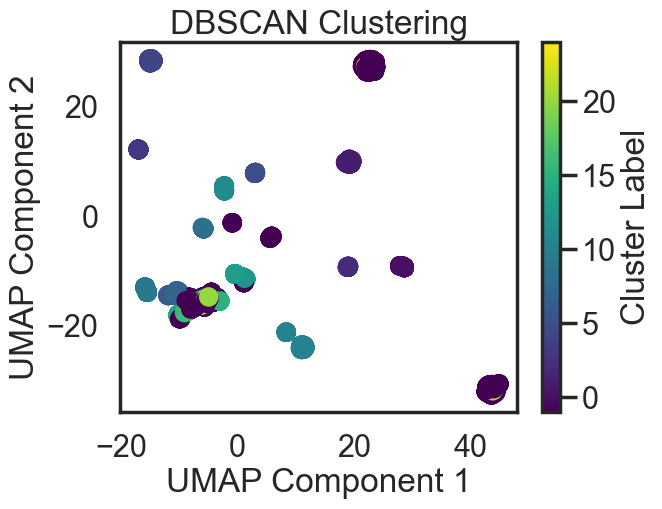

In [161]:
# Visualize the clusters
plt.scatter(data["Component 1"], data["Component 2"], c=clusters, cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster Label')
plt.show()

In [79]:
import plotly.express as px

fig = px.scatter_3d(
    data_frame=data,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=["taxon_id", "media_id"],
    template="plotly_white"
)
fig.update_traces(marker={'size': 5})
fig.show()

In [180]:
import numpy as np
import pandas as pd
from umap import UMAP
import matplotlib.pyplot as plt
import hdbscan

# Load your dataset
data = reduced_df.copy()

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_method="leaf", leaf_size=40, gen_min_span_tree=True)
clusters = clusterer.fit_predict(data)

# Add the cluster labels to the data
data['Cluster'] = clusters

# Add ID columns
data[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

#data.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
print(clusterer.labels_.max(), "clusters")
data.head()

67 clusters


,Component 1,Component 2,Component 3,Cluster,taxon_id,media_id
0,43.102425,-31.357597,-64.888351,-1,103836,J104
1,-14.944263,28.323095,1.858287,26,76637,J28
2,19.352890,10.042732,32.780693,35,589240,J104
3,11.023548,-23.688835,19.882507,43,1036778,1a
4,-0.348978,-10.678181,-4.068751,8,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


<Axes: ylabel='$\\lambda$ value'>

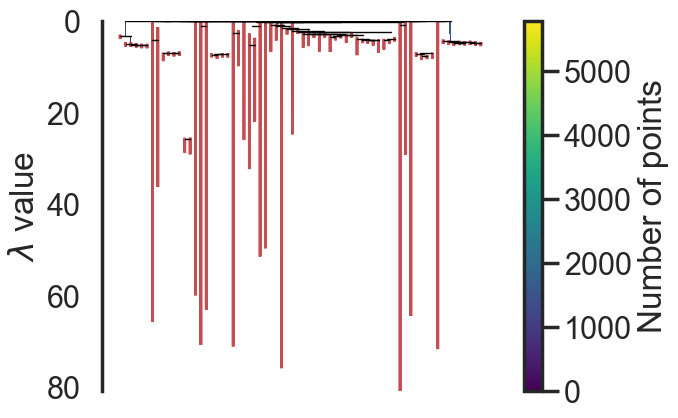

In [174]:
#clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=40, edge_linewidth=2)
#clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

C:\Users\jakel\AppData\Local\Temp\ipykernel_19192\3693830524.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

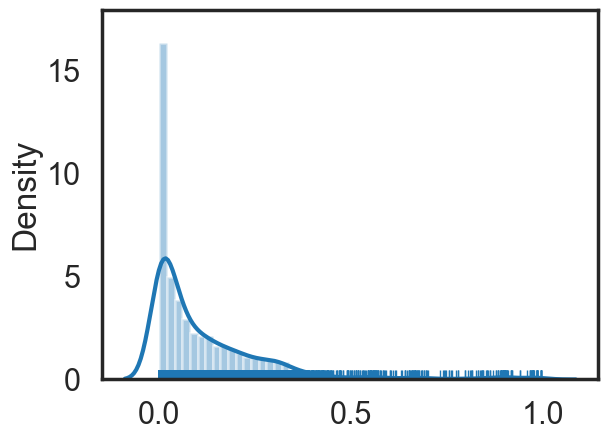

In [183]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In [208]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.5)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

#plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
#plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

#TODO: omit outliers, or label with this threshold data

## Classify

In [219]:
y_train = clusterer.fit_predict(reducer.transform(X_train))
y_test = clusterer.fit_predict(reducer.transform(X_test))

y_train

array([-1, 26, 35, ..., 50, -1, -1], dtype=int64)

In [221]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

## Metrics

In [222]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

          -1       0.52      0.80      0.63       744
           0       0.00      0.00      0.00        21
           1       0.18      0.02      0.04        95
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00        25
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00        93
          11       0.00      0.00      0.00        50
          12       0.00      0.00      0.00        36
          13       0.00      0.00      0.00        77
          14       0.00      0.00      0.00        83
          15       0.00      0.00      0.00        22
          16       0.00    

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [227]:
from sklearn import metrics

roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'